In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
import json
import sqlite3

In [2]:
def load_data(path):
    extension = path.split('.')[-1]
    if extension == 'csv':
        data = pd.read_csv(path)
    elif extension == 'json':
        with open(path, 'r') as json_file:
            data = json.load(json_file)
    elif extension == "xlsx":
        data = pd.read_excel(path)
    elif extension == 'txt':
        with open(path, 'r') as file:
            data = file.read()
    elif extension == 'db':
        conn = sqlite3.connect(path)
        query = "SELECT * FROM YourTableName;"
        data = pd.read_sql(query, conn)
        conn.close()
    else:
        raise ValueError("Unsupported file extension")
    return data

In [3]:
path = 'Online Retail.xlsx'
#path=input()
df = load_data(path)


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
num_cols = df.select_dtypes(include='number')
cat_cols = df.select_dtypes(exclude='number')

for col in num_cols.columns:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cat_cols.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency, Frequency, and Monetary
current_date = max(df['InvoiceDate'])
df['Recency'] = (current_date - df['InvoiceDate']).dt.days
df['Frequency'] = df.groupby('CustomerID')['CustomerID'].transform('count')
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'Monetary': 'sum',
    'Frequency':'mean',
    'BasketSize': 'mean'
    
}).reset_index()

#df = df.drop(['Description', 'Country'], axis=1)

df.head(5)

,CustomerID,Recency,OrderFrequency,Monetary,Frequency,BasketSize
0,12346.0,325,2.0,0.00,2.0,0.000000
1,12347.0,1,7.0,163.16,182.0,351.142857
2,12348.0,74,4.0,331.36,31.0,585.250000
3,12349.0,18,1.0,15.00,73.0,631.000000
4,12350.0,309,1.0,25.20,17.0,197.000000


In [8]:
num_cols

,Quantity,UnitPrice,CustomerID
0,6,2.55,17850.0
1,6,3.39,17850.0
2,8,2.75,17850.0
3,6,3.39,17850.0
4,6,3.39,17850.0
...,...,...,...
541904,12,0.85,12680.0
541905,6,2.10,12680.0
541906,4,4.15,12680.0
541907,4,4.15,12680.0


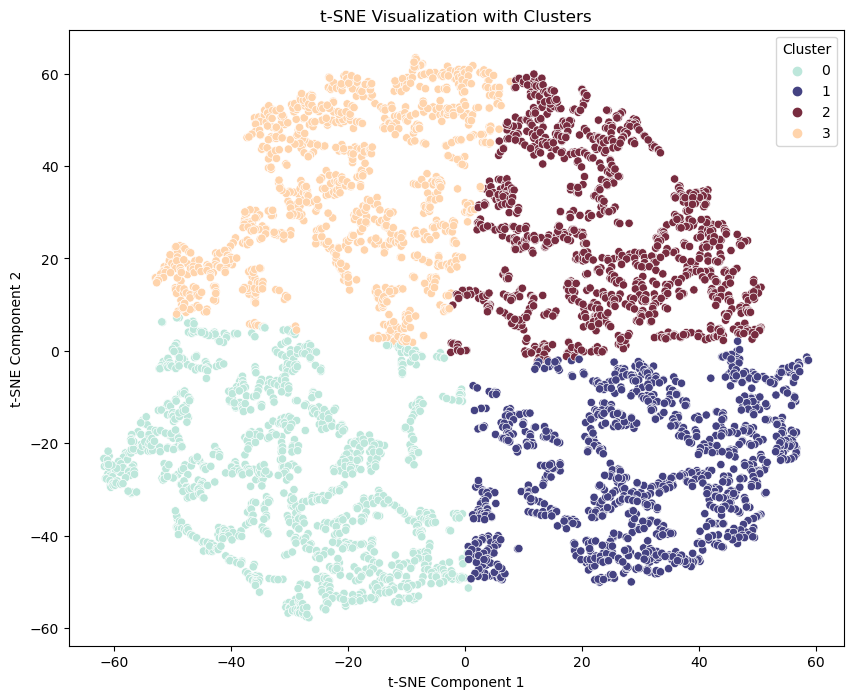

In [9]:
num_cols = df.select_dtypes(include='number')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler=StandardScaler()
scaled_data=scaler.fit_transform(num_cols)
num_components = min(num_cols.shape[0], num_cols.shape[1])

pca=PCA(n_components=num_components)
pca_results=pca.fit_transform(scaled_data)

for i in range(pca_results.shape[1]):
    df[f"Pca_compnant_{i+1}"]=pca_results[:,i]
    
from sklearn.manifold import TSNE

# Assuming pca_results is your high-dimensional data
tsne = TSNE(n_components=2) 
tsne_result = tsne.fit_transform(pca_results)
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

K = 4

kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)

df['Cluster'] = kmeans.fit_predict(tsne_result)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='icefire')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


In [10]:
df.head()

,CustomerID,Recency,OrderFrequency,Monetary,Frequency,BasketSize,Pca_compnant_1,Pca_compnant_2,Pca_compnant_3,Pca_compnant_4,Pca_compnant_5,Pca_compnant_6,t-SNE_Component_1,t-SNE_Component_2,Cluster
0,12346.0,325,2.0,0.00,2.0,0.000000,-0.094326,-0.897111,2.809726,0.073423,0.081110,-0.008723,-58.485874,-24.861977,0
1,12347.0,1,7.0,163.16,182.0,351.142857,0.040492,1.634428,0.748857,-0.857748,-0.033785,0.016327,-25.352104,25.999693,3
2,12348.0,74,4.0,331.36,31.0,585.250000,-0.087310,1.731621,1.193587,0.060049,-0.045380,-0.012043,-20.194452,15.410226,3
3,12349.0,18,1.0,15.00,73.0,631.000000,-0.046942,2.130663,0.842325,-0.135120,-0.171050,0.026864,-21.469416,18.205772,3
4,12350.0,309,1.0,25.20,17.0,197.000000,-0.110264,-0.390963,2.696247,0.435290,0.040013,0.003417,-61.164734,-22.926512,0


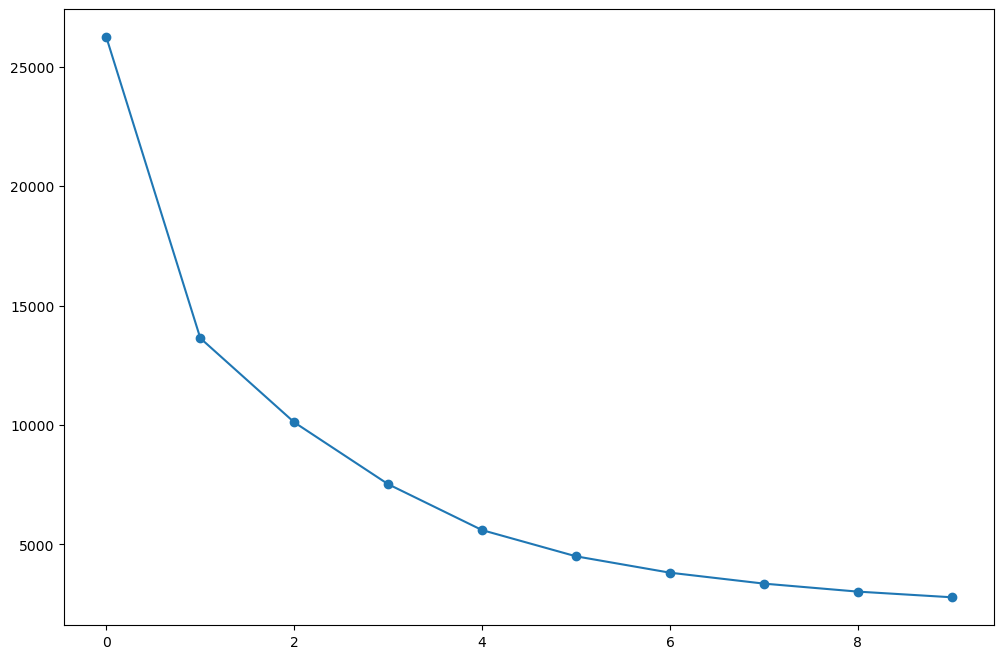

In [11]:
from sklearn.cluster import KMeans

inertia=[]

for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12,8))
plt.plot(inertia, marker="o")

In [13]:
rfm=df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',
    'Monetary': 'mean', 
    'BasketSize': 'mean', 
}).reset_index()
rfm.columns=["Cluster","AvgRecency","AvgOrderFrequency","AvgMonetary","AvgBasketSize"]
rfm

,Cluster,AvgRecency,AvgOrderFrequency,AvgFrequency,AvgMonetary,AvgBasketSize
0,0,230.281378,2.322395,34.600492,197.635890,214.328212
1,1,44.874528,5.440566,100.105660,173.043302,176.456823
2,2,30.440000,5.940488,117.964878,178.404624,165.705697
3,3,36.086997,10.489242,255.102900,-18.628746,226.710105


In [51]:
distinguishing_characteristics = {}
for cluster in range(len(rfm)):
    cluster_row=rfm.iloc[cluster]
    cluster_num=cluster_row["Cluster"]
    cluster_name = f"Cluster {int(cluster_num)}"
    
    h_value_col=cluster_row[1:].idxmax()
    h_value=cluster_row[h_value_col]
    
    
    distinguishing_characteristics[cluster_name]={"Characteristics":h_value_col,
                                   "Highest_Value":h_value}
for cluster, clus_info in distinguishing_characteristics.items():
    print(f"{cluster} has the highest {clus_info['Characteristics']} ({clus_info['Highest_Value']}).")




Cluster 0 has the highest AvgRecency (230.2813781788351).
Cluster 1 has the highest AvgBasketSize (176.45682335482334).
Cluster 2 has the highest AvgMonetary (178.4046243902439).
Cluster 3 has the highest AvgFrequency (255.10289990645464).


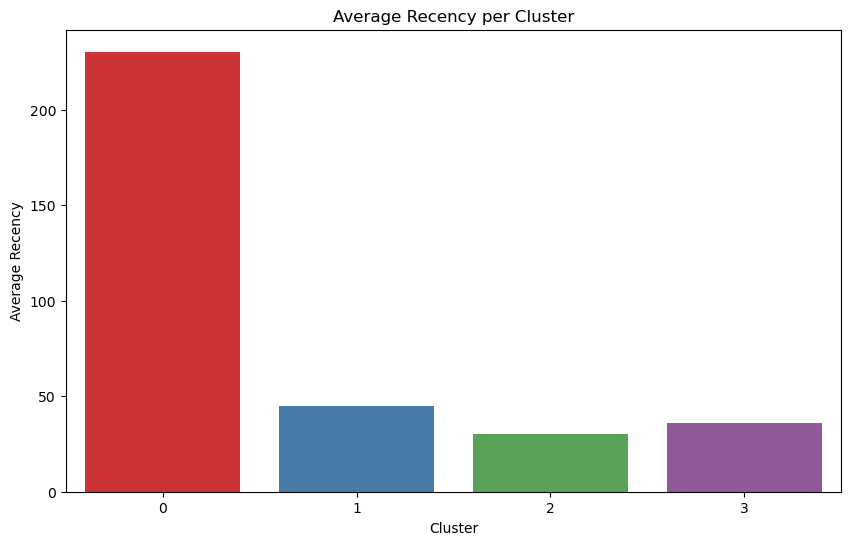

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=rfm, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

Cluster 0 This cluster exhibits the highest average recency, indicating that these customers have not made purchases recently. They also have a relatively low average purchase frequency and spending. Their basket size is moderate. These customers might be considered as inactive or lapsed customers.

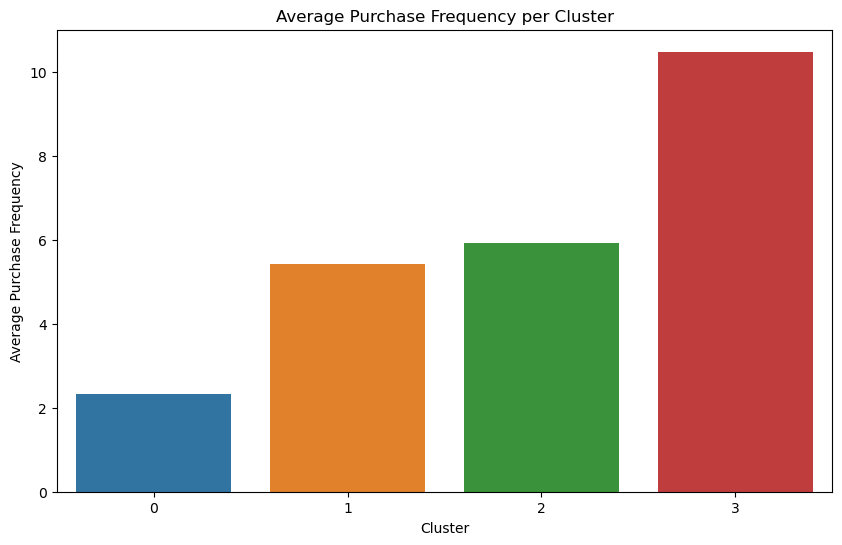

In [56]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgOrderFrequency', data=rfm)
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

Cluster 3 This cluster has a relatively low average recency, indicating recent purchases. However, they have the highest average purchase frequency, suggesting they are highly frequent shoppers. They also have moderate spending and a significantly larger basket size than other clusters, indicating large purchases. These customers are valuable and should be targeted for retention and upselling.


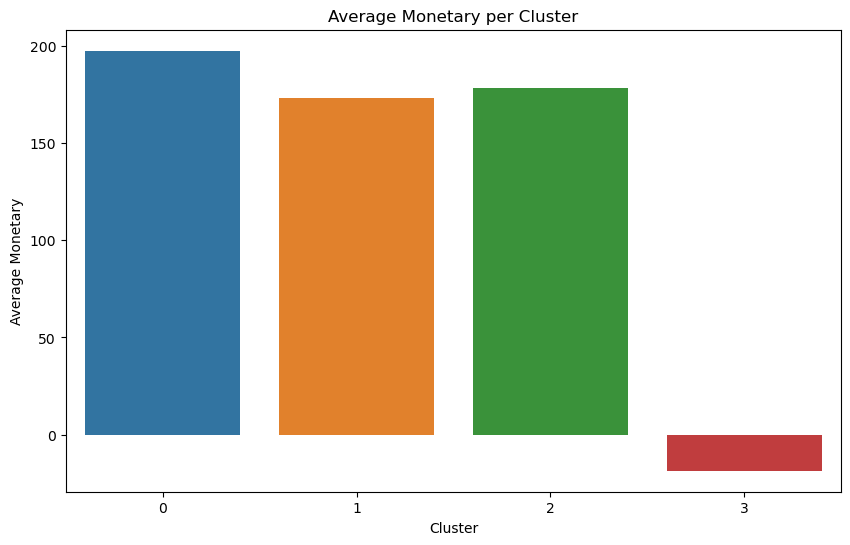

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgMonetary', data=rfm)
plt.title('Average Monetary per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary')
plt.show()

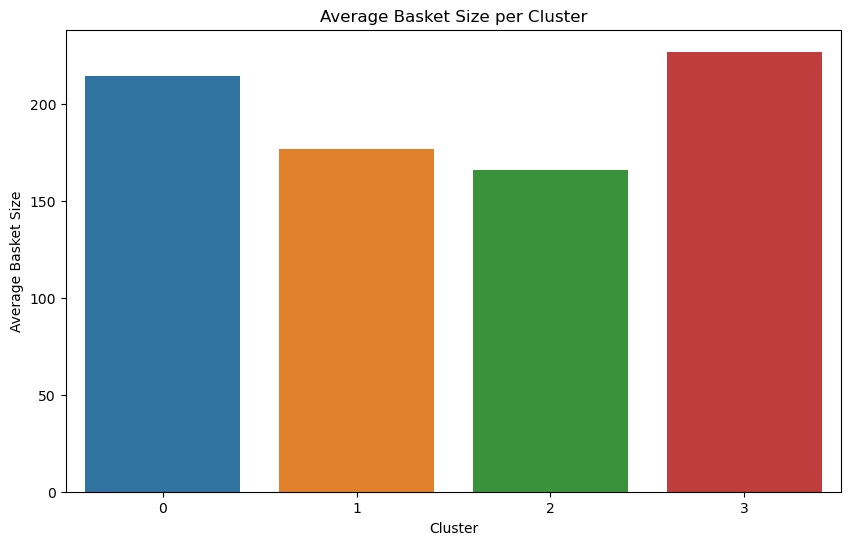

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=rfm)
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()

Conclusion
Interpretation and Insights into Customer Segments
Cluster 0 This cluster exhibits the highest average recency, indicating that these customers have not made purchases recently. They also have a relatively low average purchase frequency and spending. Their basket size is moderate. These customers might be considered as inactive or lapsed customers.

Cluster 1 This cluster does not have a distinguishing characteristic compared to other clusters. It represents a group of customers with no specific standout behavior. Further analysis might be needed to understand their preferences better.

Cluster 2 Customers in this cluster have a shorter reception, indicating recent purchases. They also exhibit a high average purchase frequency, spending, and a moderate basket size. This group appears to be active and frequent shoppers.

Cluster 3 This cluster has a relatively low average recency, indicating recent purchases. However, they have the highest average purchase frequency, suggesting they are highly frequent shoppers. They also have moderate spending and a significantly larger basket size than other clusters, indicating large purchases. These customers are valuable and should be targeted for retention and upselling.

Implications for E-commerce Business
Targeted Marketing Understanding customer segments allows for more personalized marketing strategies. Cluster 0 may benefit from reactivation campaigns, while Cluster 2 and 3 might respond well to exclusive offers.

Customer Retention For Cluster 3, focus on retaining these high-value customers through personalized offers and excellent customer service.

Inventory Management Different clusters have varying purchase frequencies and basket sizes. Use this information for demand forecasting and inventory management. High-value clusters may lead to higher demand for certain products.